# Defect Classifier


In [264]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.set_soft_device_placement(True)
    except:
        pass


ModuleNotFoundError: No module named 'seaborn'

In [256]:
DATASET_PATH = Path('/Users/willekjellberg/.cache/kagglehub/datasets/zhangyunsheng/defects-class-and-location/versions/1/images/images')
CLASSES = ['crease', 'crescent_gap', 'inclusion', 'oil_spot', 'punching_hole', 'rolled_pit', 'silk_spot']

def preprocess_image(img_path):
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    # Remove black borders
    rows = np.any(img > 0, axis=1)
    cols = np.any(img > 0, axis=0)
    if rows.any() and cols.any():
        img = img[rows][:, cols]
    img = cv2.resize(img, (224, 224)).astype(np.float32) / 255.0
    return img[..., np.newaxis]


In [257]:
# Load data
X, y = [], []
for cls in CLASSES:
    for img_path in (DATASET_PATH / cls).glob('*.jpg'):
        img = preprocess_image(img_path)
        if img is not None:
            X.append(img)
            y.append(cls)

X = np.array(X)
y = np.array(y)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
y_categorical = utils.to_categorical(y_encoded, num_classes)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded
)


In [258]:
# Simple CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_132 (Conv2D)             │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_102               │ (None, 111, 111, 32)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_133 (Conv2D)             │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_103               │ (None, 54, 54, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_134 (Conv2D)             │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_104               │ (None, 26, 26, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_141 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,383 (396.03 KB)

 Trainable params: 101,383 (396.03 KB)

 Non-trainable params: 0 (0.00 B)

In [259]:
# Class weights
y_train_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weight_dict = dict(enumerate(class_weights))

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

# Train
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    steps_per_epoch=len(X_train) // 64,
    epochs=60,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.0972 - loss: 1.9254 - val_accuracy: 0.0469 - val_loss: 1.9427
Epoch 2/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1562 - loss: 2.5156 - val_accuracy: 0.0437 - val_loss: 1.9418
Epoch 3/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.1376 - loss: 1.9445 - val_accuracy: 0.0750 - val_loss: 1.9442
Epoch 4/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1719 - loss: 1.7588 - val_accuracy: 0.0781 - val_loss: 1.9439
Epoch 5/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.1820 - loss: 1.9050 - val_accuracy: 0.1406 - val_loss: 1.8915
Epoch 6/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1406 - loss: 1.9980 - val_accuracy: 0.1094 - val_loss: 1.8961
Epoch 7/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.1845 - loss: 1.8497 - val_accuracy: 0.1437 - val_loss: 1.8755
Epoch 8/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1875 - loss: 1.7781 - val_accuracy: 0.1437 - val_l

Test Accuracy: 0.3313


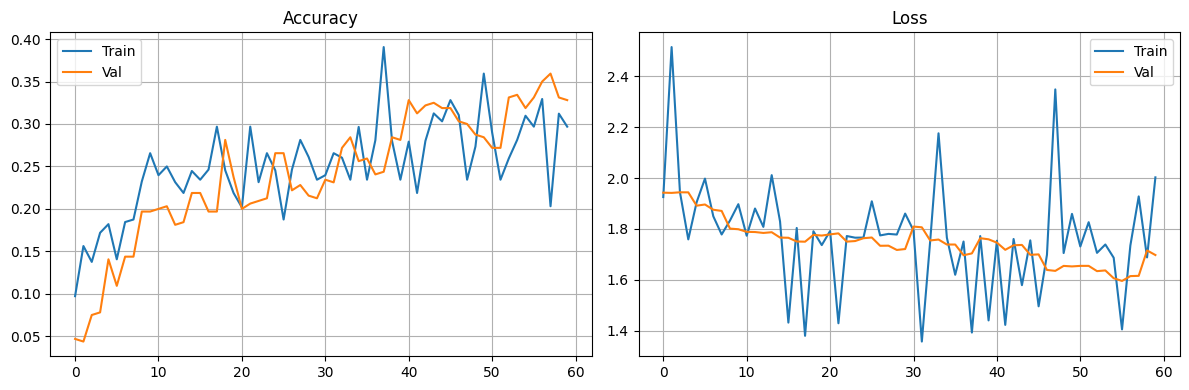

In [260]:
# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history.history['accuracy'], label='Train')
axes[0].plot(history.history['val_accuracy'], label='Val')
axes[0].set_title('Accuracy')
axes[0].legend()
axes[0].grid(True)
axes[1].plot(history.history['loss'], label='Train')
axes[1].plot(history.history['val_loss'], label='Val')
axes[1].set_title('Loss')
axes[1].legend()
axes[1].grid(True)
plt.tight_layout()
plt.show()


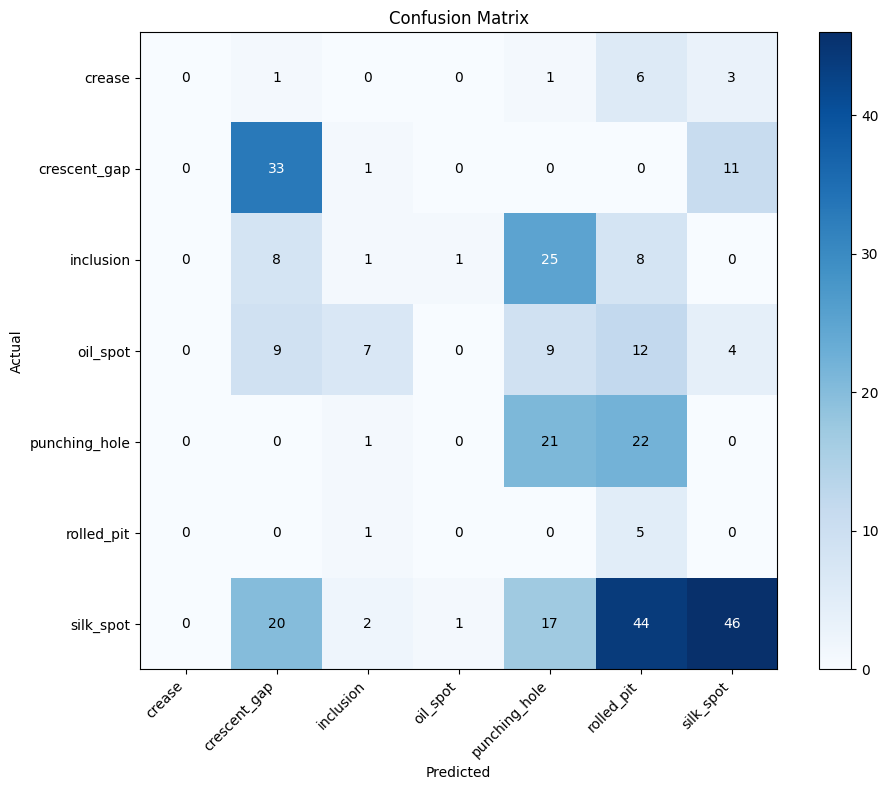


Classification Report:
               precision    recall  f1-score   support

       crease       0.00      0.00      0.00        11
 crescent_gap       0.46      0.73      0.57        45
    inclusion       0.08      0.02      0.04        43
     oil_spot       0.00      0.00      0.00        41
punching_hole       0.29      0.48      0.36        44
   rolled_pit       0.05      0.83      0.10         6
    silk_spot       0.72      0.35      0.47       130

     accuracy                           0.33       320
    macro avg       0.23      0.35      0.22       320
 weighted avg       0.41      0.33      0.33       320



In [ ]:
# Confusion Matrix
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


In [262]:
model.save('defect_classifier_model.h5')
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)


In [263]:
def predict(image_path):
    img = preprocess_image(image_path)
    if img is None:
        return None
    pred = model.predict(np.expand_dims(img, axis=0), verbose=0)[0]
    class_idx = np.argmax(pred)
    return label_encoder.classes_[class_idx], pred[class_idx]
